In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
import geopandas as gpd
import shapefile as shp
from shapely.geometry import Point

In [3]:
#base_path = 'C:/GitHub/Data-Analytics-Case-2_LOCAL/data/'
# Reading holidays_events.csv without specific issues mentioned, but keep an eye for potential encoding errors
# Reading items.csv with consideration for mixed types
# Reading oil.csv, noting there might be lines with missing data (';;')
# Reading stores.csv with specified encoding to address potential UnicodeDecodeError
# Reading transactions.csv without specific issues mentioned
# Reading data.csv with consideration for mixed types
# Reading test.csv without specific issues mentioned

base_path = 'data/'
holidays_events = pd.read_csv(base_path + 'holidays_events.csv')
items = pd.read_csv(base_path + 'items.csv')
oil = pd.read_csv(base_path + 'oil.csv')
oil_INR = pd.read_csv(base_path + 'oil(INR).csv', sep=',', skipinitialspace=True)
stores = pd.read_csv(base_path + 'stores.csv')
transactions = pd.read_csv(base_path + 'transactions.csv')

test = pd.read_csv('dataRaw/test.csv', sep=',')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

data = pd.read_csv('dataRaw/data.csv', sep=',', low_memory=False)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['unit_sales'] = data['unit_sales'].round(2)
data['onpromotion'].fillna(False, inplace=True)


C:\Users\Cursist\AppData\Local\Temp\ipykernel_16708\1662035945.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['onpromotion'].fillna(False, inplace=True)
C:\Users\Cursist\AppData\Local\Temp\ipykernel_16708\1662035945.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['onpromotion'].fillna(False

Start with TEST visualization
-> statistical analysis of numerical data regarding outliers

Original DataFrame shape: (3370464, 5)
DataFrame shape after removing outliers: (3370464, 5)


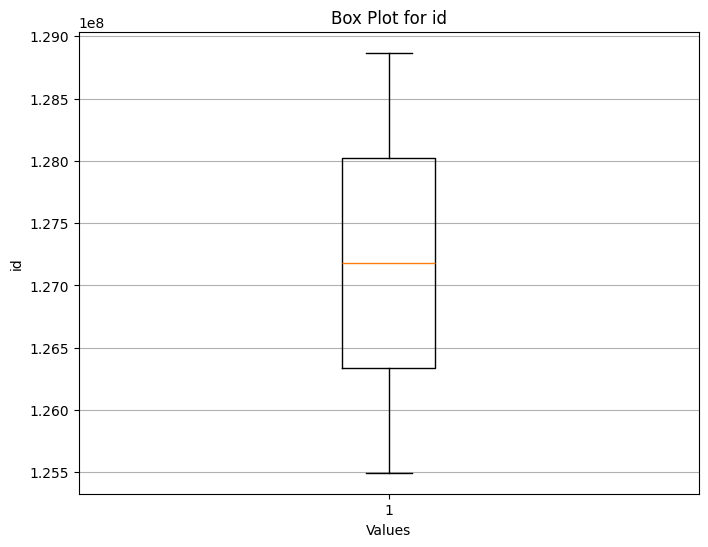

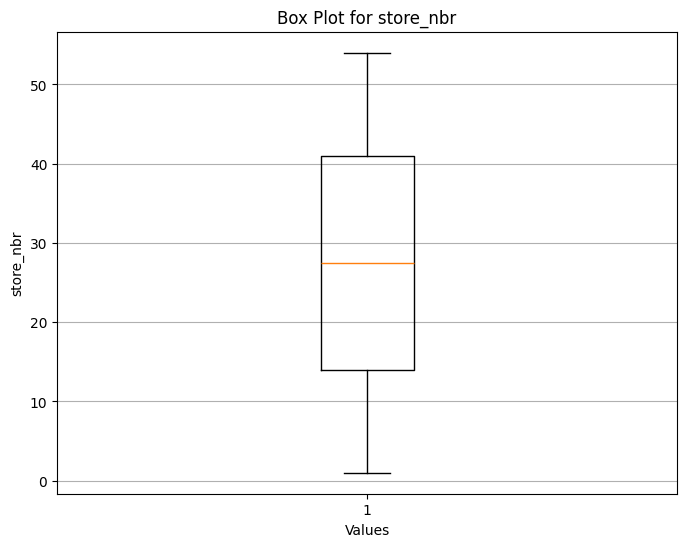

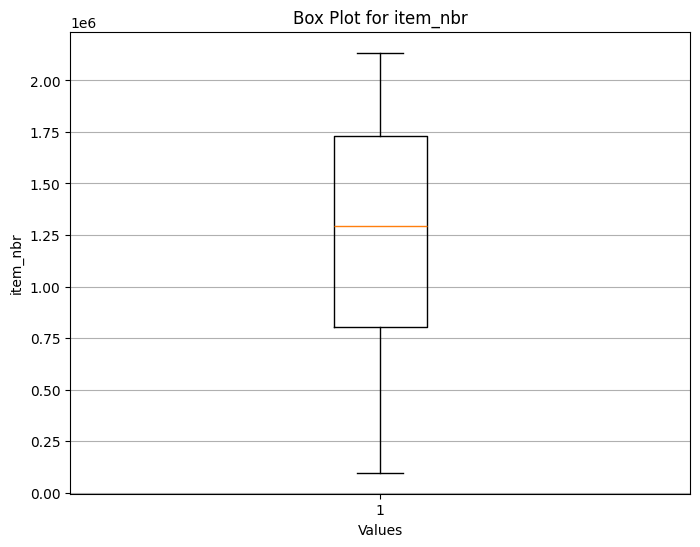

In [4]:
# Notes:
# 1. For files like 'oil(India).csv' where there are potential empty fields (';;'), skipinitialspace=True helps clean up any leading spaces after the separator, which might help in correctly parsing the fields.
# 2. If any of these files still present challenges, consider specifying dtype for columns with mixed types, or exploring the files manually to identify further specific needs (like missing values handling, encoding, etc.).

# Assuming 'test' is your DataFrame
# Select only the numeric columns (excluding 'date' and 'onpromotion')
numeric_columns = ['id', 'store_nbr', 'item_nbr']

# Calculate the IQR for each numeric column
Q1 = test[numeric_columns].quantile(0.25)
Q3 = test[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outlier indices using Boolean arrays
outlier_indices = ((test[numeric_columns] < (Q1 - 1.5 * IQR)) | (test[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Create a new DataFrame without outliers
df_no_outliers = test[~outlier_indices]

print("Original DataFrame shape:", test.shape)
print("DataFrame shape after removing outliers:", df_no_outliers.shape)

# Create a separate box plot for each numeric column
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(test[col])
    plt.title(f"Box Plot for {col}")
    plt.xlabel("Values")
    plt.ylabel(col)
    plt.grid(axis='y')
    plt.show()



TEST visualization
-> consistancy of the dataset

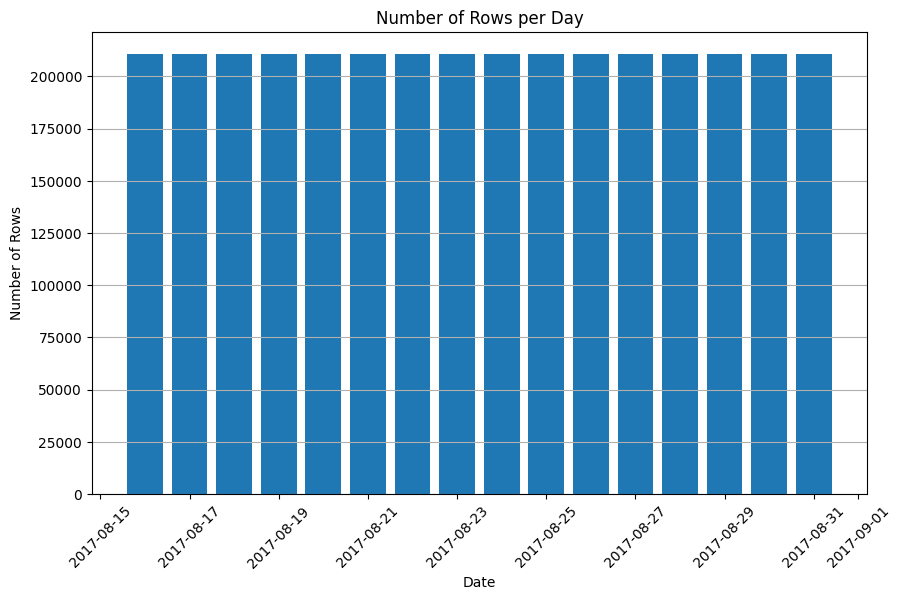

In [5]:
# Group by date and count the number of rows per day
daily_counts = test.groupby(test['date'].dt.date).size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(daily_counts.index, daily_counts.values) # type: ignore
plt.title("Number of Rows per Day")
plt.xlabel("Date")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y')
plt.show()

TEST visualization
-> what is on promotion?

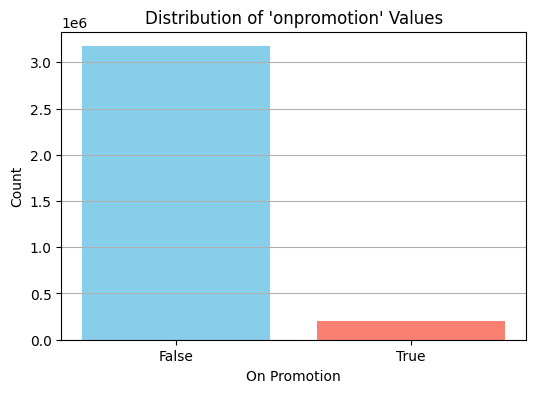

onpromotion
False    3171867
True      198597
Name: count, dtype: int64


In [6]:
# Create a count of True and False values
promotion_counts = test['onpromotion'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(promotion_counts.index, promotion_counts.values, color=['skyblue', 'salmon']) # type: ignore
plt.title("Distribution of 'onpromotion' Values")
plt.xlabel("On Promotion")
plt.ylabel("Count")
plt.xticks([0, 1], ['False', 'True'])  # Set x-axis labels
plt.grid(axis='y')
plt.show()

print(promotion_counts)

Continue with DATA visualization
-> evolution of the amount of sales

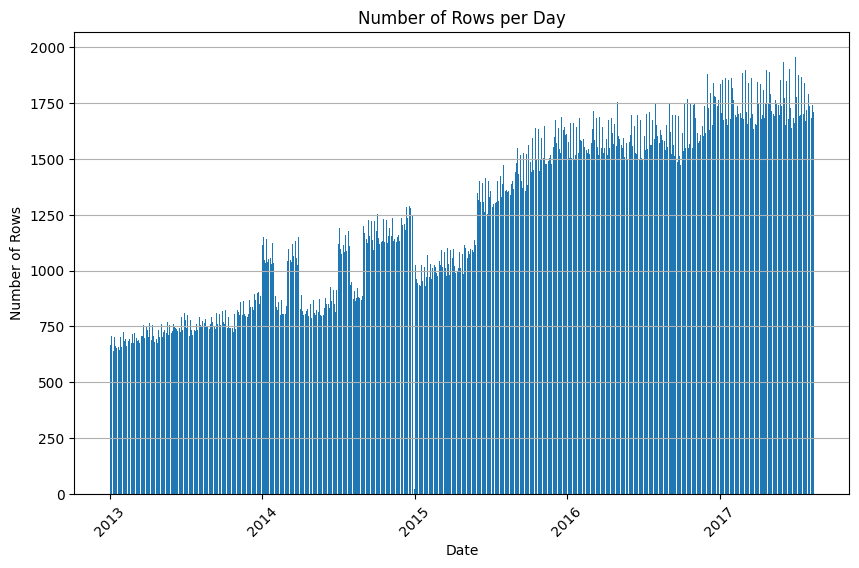

In [7]:
# Group by date and count the number of rows per day
daily_counts = data.groupby(data['date'].dt.date).size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(daily_counts.index, daily_counts.values) # type: ignore
plt.title("Number of Rows per Day")
plt.xlabel("Date")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y')
plt.show()

Continue with DATA visualization
-> evolution of the amount of sales (better visualization)

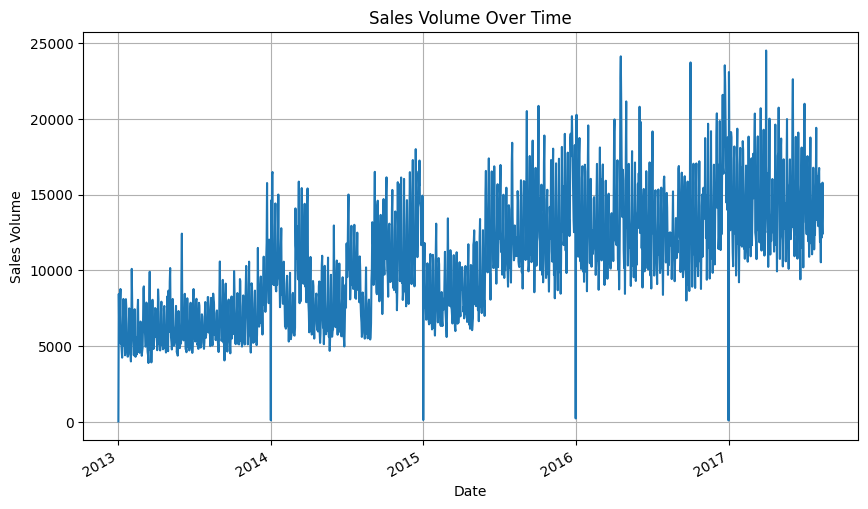

In [8]:
# Group by date and sum the unit_sales
sales_over_time = data.groupby('date')['unit_sales'].sum()

# Create the line chart
sales_over_time.plot(kind='line', figsize=(10, 6))
plt.title('Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.grid(True)
plt.show()



Continue with DATA visualization
-> sales distribution acros stores

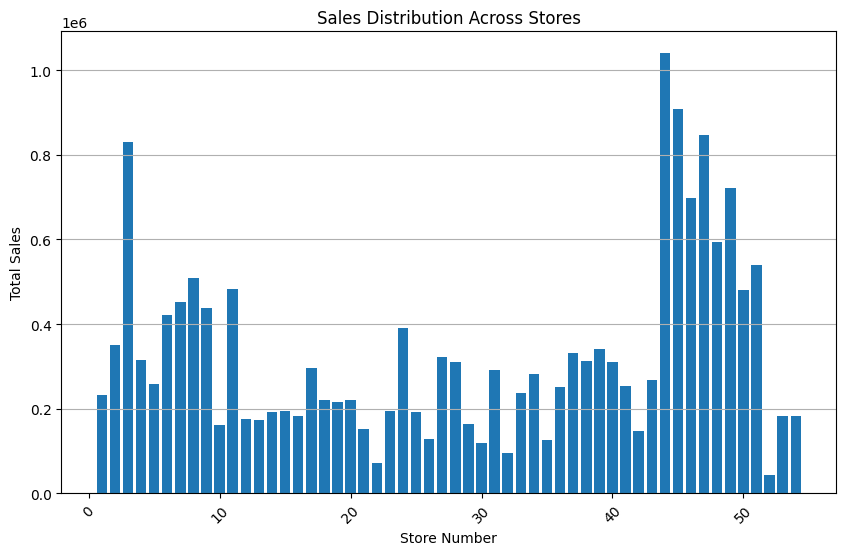

store nr 44 has the highest sales


In [9]:
# Group by store_nbr and sum the unit_sales
sales_by_store = data.groupby('store_nbr')['unit_sales'].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sales_by_store.index, sales_by_store.values) # type: ignore
plt.title('Sales Distribution Across Stores')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

print("store nr 44 has the highest sales")

Continue with DATA visualization
-> sales distribution acros items

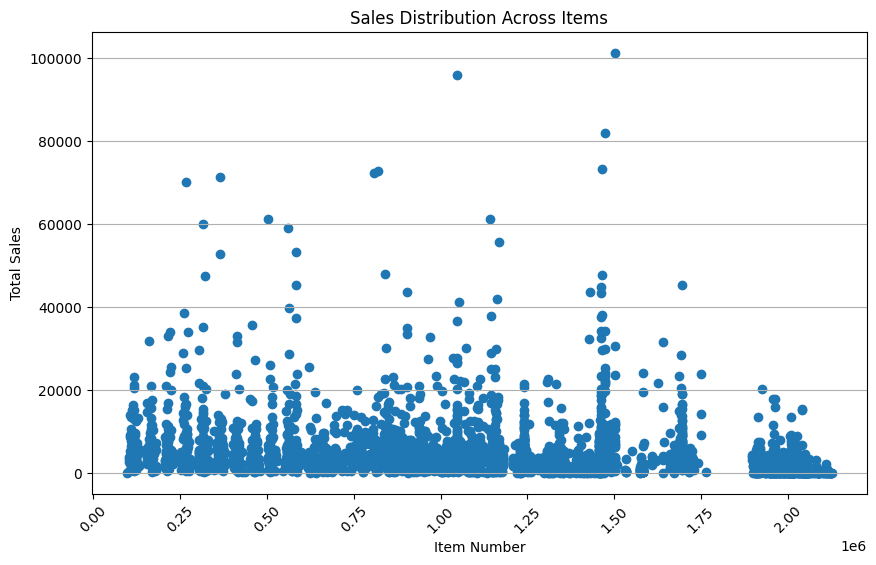

we can see that the store is closed or some periods of time


In [10]:
# Group by item_nbr and sum the unit_sales
sales_by_item = data.groupby('item_nbr')['unit_sales'].sum()

# Sort the sales in descending order
sales_by_item = sales_by_item.sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.scatter(sales_by_item.index, sales_by_item.values) # type: ignore
plt.title('Sales Distribution Across Items')
plt.xlabel('Item Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

print("we can see that the store is closed or some periods of time")

Continue with DATA visualization
-> negative sales, items that are returned

In [11]:
data.info()
data['unit_sales'].describe()

print("Er zijn 138 items geretourneerd naar de winkels waardoor de unit_sales negatief zijn")
negative_sales = data[data['unit_sales'] < 0]
negative_sales.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091618 entries, 0 to 2091617
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Unnamed: 0   int64         
 1   id           int64         
 2   date         datetime64[ns]
 3   store_nbr    int64         
 4   item_nbr     int64         
 5   unit_sales   float64       
 6   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4)
memory usage: 97.7 MB
Er zijn 138 items geretourneerd naar de winkels waardoor de unit_sales negatief zijn


,Unnamed: 0,id,date,store_nbr,item_nbr,unit_sales
count,1.380000e+02,1.380000e+02,138,138.000000,1.380000e+02,138.000000
mean,6.540077e+07,6.540077e+07,2015-10-19 06:26:05.217391360,24.065217,1.107218e+06,-8.280000
min,3.982800e+05,3.982800e+05,2013-01-11 00:00:00,1.000000,1.035200e+05,-300.000000
25%,3.343184e+07,3.343184e+07,2014-10-20 06:00:00,8.000000,6.836718e+05,-3.000000
50%,6.844281e+07,6.844281e+07,2016-01-22 12:00:00,20.000000,1.169343e+06,-1.000000
75%,9.657078e+07,9.657078e+07,2016-11-11 00:00:00,41.000000,1.464239e+06,-1.000000
max,1.232944e+08,1.232944e+08,2017-07-25 00:00:00,54.000000,2.045493e+06,-0.820000
std,3.582318e+07,3.582318e+07,NaN,17.080833,5.370882e+05,32.312752


meeste van de producten die geretourneerd zijn hebben een unit_sales van -1
dat betekend dat er meestal 1 product is geretourneerd


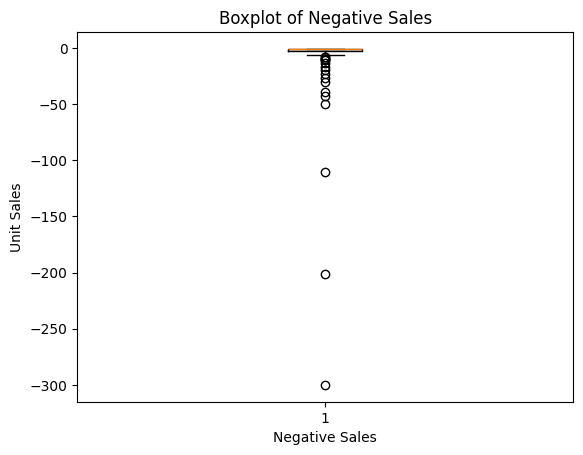

In [12]:
print("meeste van de producten die geretourneerd zijn hebben een unit_sales van -1")
print("dat betekend dat er meestal 1 product is geretourneerd")

plt.boxplot(negative_sales['unit_sales'])
plt.xlabel('Negative Sales')
plt.ylabel('Unit Sales')
plt.title('Boxplot of Negative Sales')
plt.show()


In [13]:
print(data['onpromotion'].value_counts())
print(data['onpromotion'].isna().sum())
data['onpromotion'].fillna(False, inplace=True)
print(data['onpromotion'].value_counts())

print('\n',"hoe veel producten die geretourneerd zijn, zijn niet in promotie?")
tmp = negative_sales[negative_sales['onpromotion']==False]
print(len(tmp))
print("er zijn dus geen producten die geretourneerd zijn die in promotie zijn")


onpromotion
False    1961389
True      130229
Name: count, dtype: int64
0
onpromotion
False    1961389
True      130229
Name: count, dtype: int64

 hoe veel producten die geretourneerd zijn, zijn niet in promotie?
138
er zijn dus geen producten die geretourneerd zijn die in promotie zijn


Continue with ITEMS visualization
-> explore

In [14]:
items.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_nbr    4100 non-null   int64  
 1   family      4100 non-null   object 
 2   class       4100 non-null   float64
 3   perishable  4100 non-null   bool   
 4   Price       4100 non-null   float64
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 132.3+ KB


In [15]:
items.describe()

,item_nbr,class,Price
count,4.100000e+03,4100.0000,4100.000000
mean,1.251436e+06,2169.6500,10.126515
std,5.876872e+05,1484.9109,15.475591
min,9.699500e+04,1002.0000,0.010000
25%,8.181108e+05,1068.0000,4.040000
50%,1.306198e+06,2004.0000,7.080000
75%,1.904918e+06,2990.5000,11.320000
max,2.134244e+06,7780.0000,240.620000


In [16]:
fig = px.treemap(items, path=['family'], title='Family Distribution')
fig.show()

In [17]:
# negative_sales.info()
# items.info()
negative_sales_expanded = negative_sales.merge(items[['item_nbr', 'family','perishable'] ], on='item_nbr', how='left')
negative_sales_expanded.info()
fig = px.treemap(negative_sales_expanded, path=['family'], title='Family Distribution')
fig.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   138 non-null    int64         
 1   id           138 non-null    int64         
 2   date         138 non-null    datetime64[ns]
 3   store_nbr    138 non-null    int64         
 4   item_nbr     138 non-null    int64         
 5   unit_sales   138 non-null    float64       
 6   onpromotion  138 non-null    bool          
 7   family       138 non-null    object        
 8   perishable   138 non-null    bool          
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 7.9+ KB


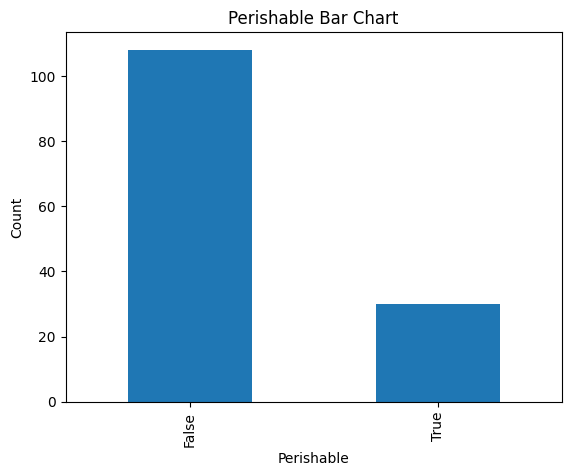

In [18]:
negative_sales_expanded['perishable'].value_counts().plot(kind='bar')
plt.xlabel('Perishable')
plt.ylabel('Count')
plt.title('Perishable Bar Chart')
plt.show()


Continue with OIL visualization
-> analyze file, seprate data

Continue with OIL visualization
-> relation crude oil price over time

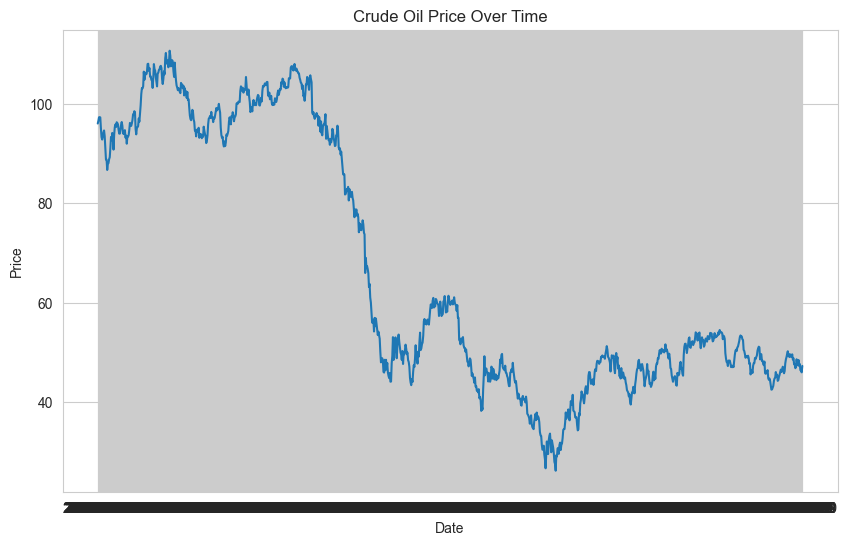

In [ ]:

# Plot the oil prices over time
plt.figure(figsize=(10, 6))
plt.plot(oil['date'], oil['dcoilwtico'])
plt.title('Crude Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
# Set the x-axis locator and formatter
ax = plt.gca()

# EXTRA: Set the locator to every year - werkt nu nog niet
""" mylocator = mdates.YearLocator()
ax.xaxis.set_major_locator(mylocator)
# Use ConciseDateFormatter to format the dates
formatter = mdates.ConciseDateFormatter(locator=mylocator)
ax.xaxis.set_major_formatter(formatter) """

plt.show()

Continue with OIL visualization
-> statistical analysis of the oil price

In [20]:
# Print the 'oil' dataframe
print(oil)
oil['dcoilwtico'].describe()

            date  dcoilwtico
0     2013-03-26       95.99
1     2013-03-27       96.53
2     2013-03-28       97.24
3     2013-04-01       97.10
4     2013-04-02       97.23
...          ...         ...
1113  2017-08-25       47.65
1114  2017-08-28       46.40
1115  2017-08-29       46.46
1116  2017-08-30       45.96
1117  2017-08-31       47.26

[1118 rows x 2 columns]


count    1118.000000
mean       66.363694
std        25.545869
min        26.190000
25%        46.180000
50%        52.375000
75%        95.530000
max       110.620000
Name: dcoilwtico, dtype: float64

Continue with HOLLYDAYS visualization
-> analyze data

         date month_day                description                type
0  1900-01-01     01-01             New Year's Day  Restricted Holiday
1  1900-01-04     01-04   Milad un-Nabi/Id-e-Milad    Gazetted Holiday
2  1900-01-05     01-05  Guru Govind Singh Jayanti          Observance
3  1900-01-07     01-07  Guru Govind Singh Jayanti  Restricted Holiday
4  1900-01-13     01-13            Makar Sankranti  Restricted Holiday


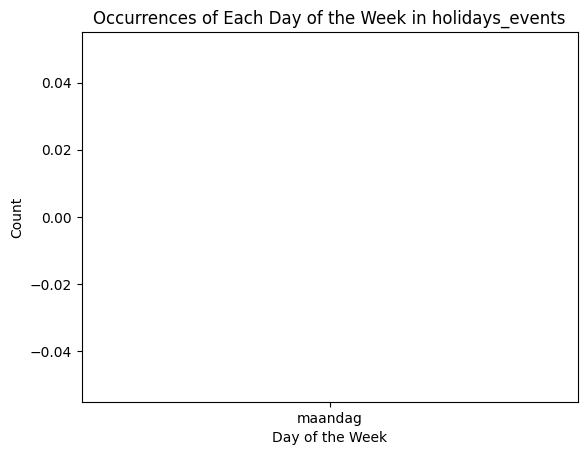

In [21]:
print(holidays_events.head())

# Count the occurrences of each day of the week
day_counts = holidays_events['type'].value_counts()

day_counts = day_counts.reindex(['maandag', 'dinsdag', 'woensdag', 'donderdag', 'vrijdag', 'zaterdag', 'zondag'])

# Create a bar chart
plt.bar(day_counts.index, day_counts.values)

# Set the labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Occurrences of Each Day of the Week in holidays_events')

# Display the chart
plt.show()



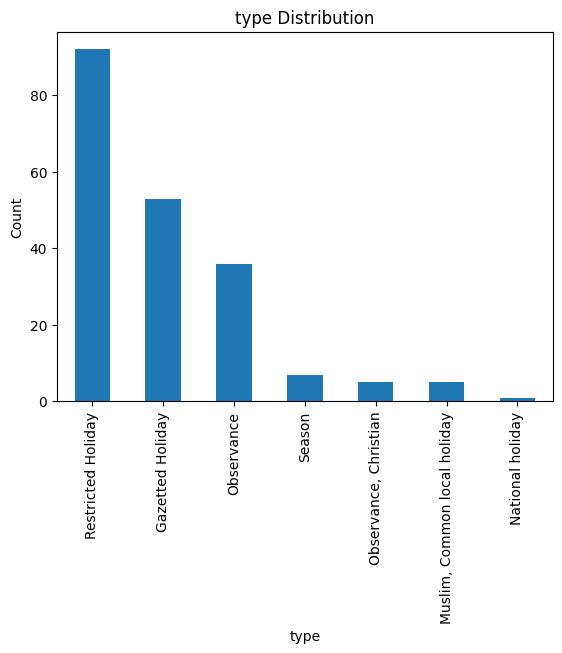

In [23]:
holidays_events['type'].value_counts().plot(kind='bar')
plt.xlabel('type')
plt.ylabel('Count')
plt.title('type Distribution')
plt.show()


In [24]:
sns.set_style('whitegrid')

#Reading the shape file
path = r'dataRaw/india-polygon.shp'
map_df = gpd.read_file(path)

# map_df.plot()
# map_df.head()
# print(map_df)

state_data = ['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal',None,None,None,None]
map_df['state'] = state_data

# print(map_df.info())
# map_df.plot()
# map_df.head()
#Merging the data
merged = map_df.set_index('state').join(stores.set_index('state'))
merged.head()


,geometry,store_nbr,Store name,city,type,cluster
state,,,,,,
Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",NaN,NaN,NaN,NaN,NaN
Andhra Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",NaN,NaN,NaN,NaN,NaN
Arunachal Pradesh,"POLYGON ((95.19594 27.03612, 95.08795 26.94578...",NaN,NaN,NaN,NaN,NaN
Assam,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",1.0,BB - FC-GUWAHATI-BHANAGAGHAR-CITY SQUARE G.S ...,GUWAHATI,D,13.0
Assam,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",4.0,FBB-GUWAHATI-PALTAN BAZAR-G.S.ROAD,GUWAHATI,D,9.0


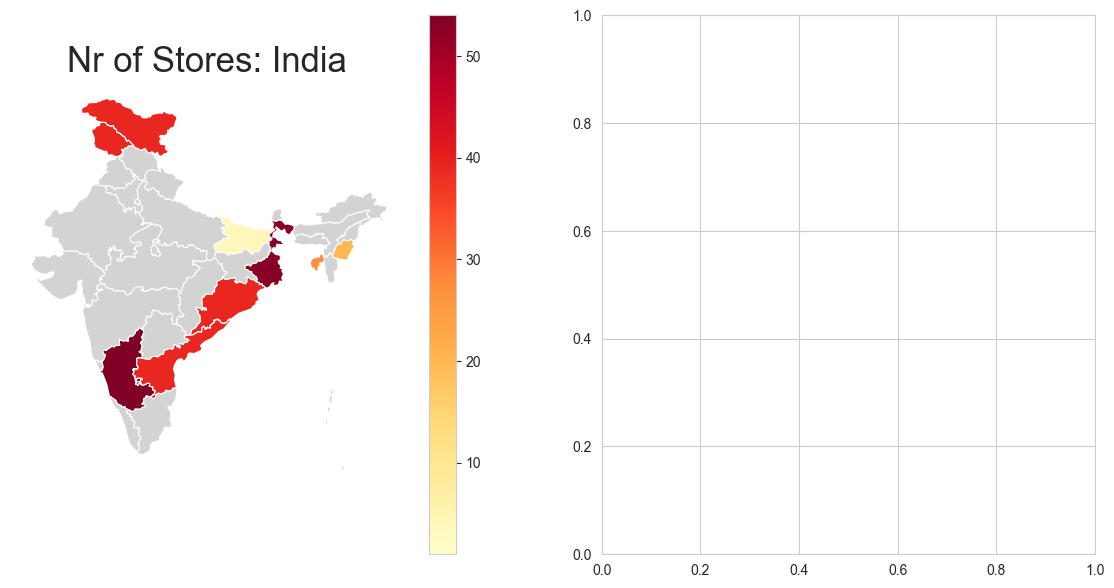

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# First map
ax1.axis('off')
ax1.set_title('Nr of Stores: India', fontdict={'fontsize': '25', 'fontweight' : '10'})
merged.plot(column='store_nbr', cmap='YlOrRd', linewidth=0.8, legend=True, ax=ax1, missing_kwds={'color': 'lightgrey'})

# Second map
# Dit is super jammermaar na 32minuten runnen is het nog niet gelukt om de tweede map te maken. crashed.
""" merged2 = map_df.set_index('state').join(stores.set_index('state'))
merged2 = merged2.set_index('store_nbr').join(data.set_index('store_nbr'))
merged2 = merged2.set_index('item_nbr').join(items.set_index('item_nbr'))
merged2.plot(column='Price', cmap='YlOrRd', linewidth=0.8, legend=True, ax=ax1, missing_kwds={'color': 'lightgrey'}) """

plt.show()
